# **1. Preparation**

In [ ]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=f7c17a5e437965a830d761beddfc6ec2e3057c7a1642b61e854dc8c30f88a39c
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [ ]:
# Import Libraries

# Suppress warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

# Main Libraries
import os  # For file and directory operations
import glob  # To search for files with specific patterns
import cv2  # OpenCV for image processing tasks
import numpy as np  # For numerical operations and array manipulations
import pandas as pd  # For data manipulation and analysis
import gc  # Garbage collection to manage memory efficiently
import string  # For string manipulation and handling
import time  # To track execution time or introduce delays
import random  # For generating random numbers or shuffling data
import imutils  # For simplifying image operations (resizing, rotating, etc.)
from PIL import Image  # For image handling and manipulation (Pillow library)
from tqdm import tqdm  # To display progress bars for loops
tqdm.pandas()  # Enable tqdm for pandas operations (e.g., `apply` with progress bar)

# Visualization Libraries
import matplotlib  # For creating static visualizations
import matplotlib.pyplot as plt  # Simplified interface for plotting with matplotlib
import plotly  # For creating interactive plots
import plotly.graph_objects as go  # Plotly's figure and graph objects
import plotly.express as px  # High-level interface for creating interactive plots
from plotly.subplots import make_subplots  # To create multi-panel plots
from sklearn.manifold import TSNE  # For dimensionality reduction and visualization

# Model and Machine Learning Libraries
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
import tensorflow as tf  # Deep learning framework
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img  # Utilities for image loading and conversion
from keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.applications import VGG16  # Pre-trained VGG16 model for image recognition tasks
from tensorflow.keras.layers import Dense, Flatten, Dropout  # Layers for building custom neural networks
from keras.models import load_model, Model  # To load or define deep learning models
from keras.optimizers import Adam  # Adam optimizer for training neural networks
from keras.callbacks import ModelCheckpoint, EarlyStopping  # To save models and stop training early if performance stops improving


In [ ]:
# Configuration Class
class CFG:
    # Batch size for training the model (number of images per training batch)
    batch_size = 64

    # Dimensions for resizing images (height and width in pixels)
    img_height = 64
    img_width = 64

    # Number of epochs (iterations over the entire dataset during training)
    epochs = 10

    # Number of classes in the dataset (e.g., for multi-class classification)
    num_classes = 29

    # Number of channels in the images (3 for RGB images)
    img_channels = 3

# Function to Set Seed for Reproducibility
def seed_everything(seed: int):
    """
    Sets the seed for various libraries to ensure reproducible results.

    Args:
        seed (int): The seed value to set.
    """
    random.seed(seed)  # Set seed for Python's random module
    os.environ["PYTHONHASHSEED"] = str(seed)  # Set seed for Python's hash-based operations
    np.random.seed(seed)  # Set seed for NumPy's random number generator
    tf.random.set_seed(seed)  # Set seed for TensorFlow's random number generator


# **2. Dataset**

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">2.1. Data Exploration</h2>
</div>

In [ ]:
# Path to the Training Data
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

# Initialize an Empty List to Store Labels
labels = []

# Create a List of the Uppercase English Alphabet (A-Z)
alphabet = list(string.ascii_uppercase)  # ['A', 'B', 'C', ..., 'Z']

# Add the Alphabet Letters to the Labels List
labels.extend(alphabet)

# Add Special ASL Labels for 'delete', 'nothing', and 'space' Gestures
labels.extend(["del", "nothing", "space"])

# Print the Final List of Labels
print(labels)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
def sample_images(labels):
    """
    Displays sample images for each label in the ASL alphabet dataset.

    Args:
        labels (list): A list of label names corresponding to subfolders in the dataset.
    """

    # Set the default height of the figure
    y_size = 12

    # Dynamically adjust the height if there are fewer than 10 labels
    if len(labels) < 10:
        y_size = y_size * len(labels) / 10

    # Create a figure with subplots (rows = number of labels, columns = 9)
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    # Loop through each label
    for i, label in enumerate(labels):
        # Add the label name as text in the first column of each row
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')  # Turn off the axis for the text cell

        # Construct the path to the directory containing images for the current label
        label_path = os.path.join(TRAIN_PATH, label)

        # List all image files in the label's directory
        list_files = os.listdir(label_path)

        # Loop to display 8 sample images for the current label
        for j in range(8):
            # Read the image using OpenCV (BGR format)
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))

            # Convert the image from BGR to RGB (matplotlib expects RGB format)
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)

            # Display the image in the corresponding subplot
            axs[i, j + 1].imshow(img_label)

            # Turn off the axis for the image cell
            axs[i, j + 1].axis("off")

    # Add a title to the entire figure
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Display the figure
    plt.show()


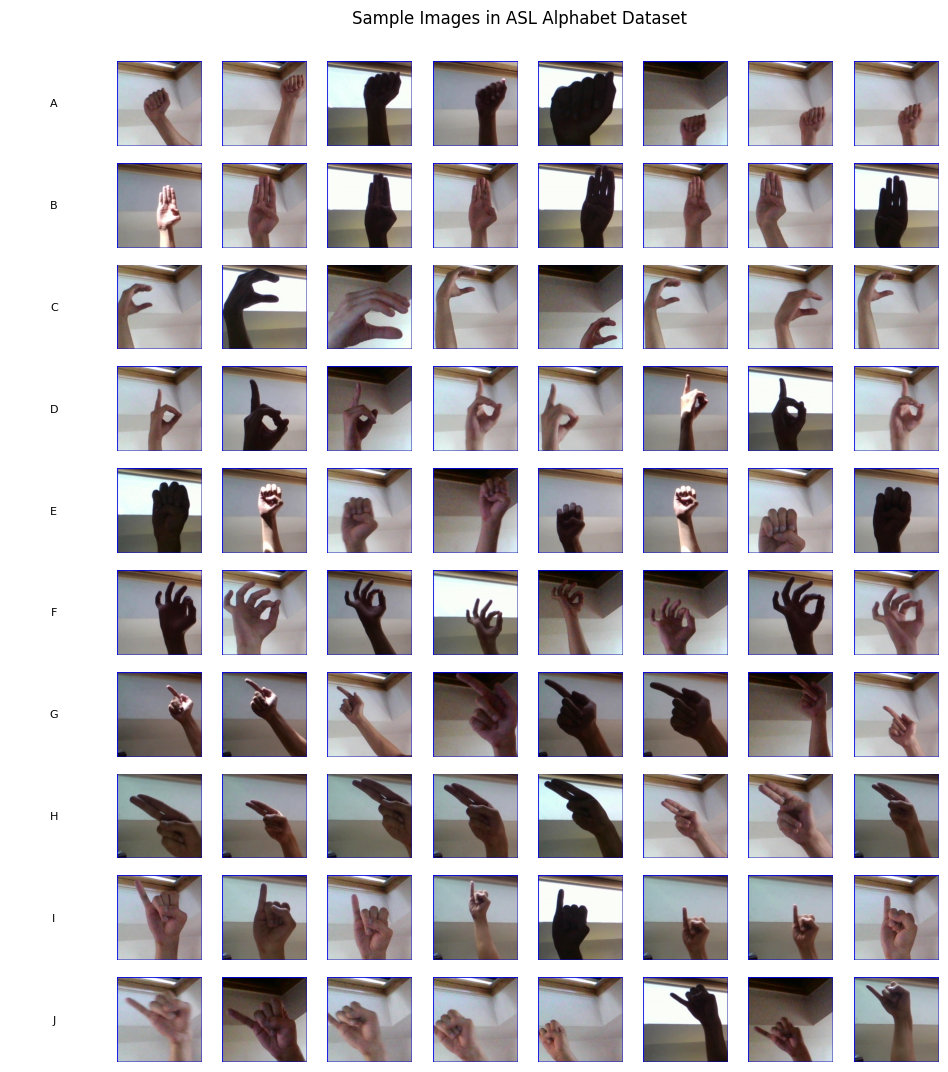

In [ ]:
sample_images(labels[:10])

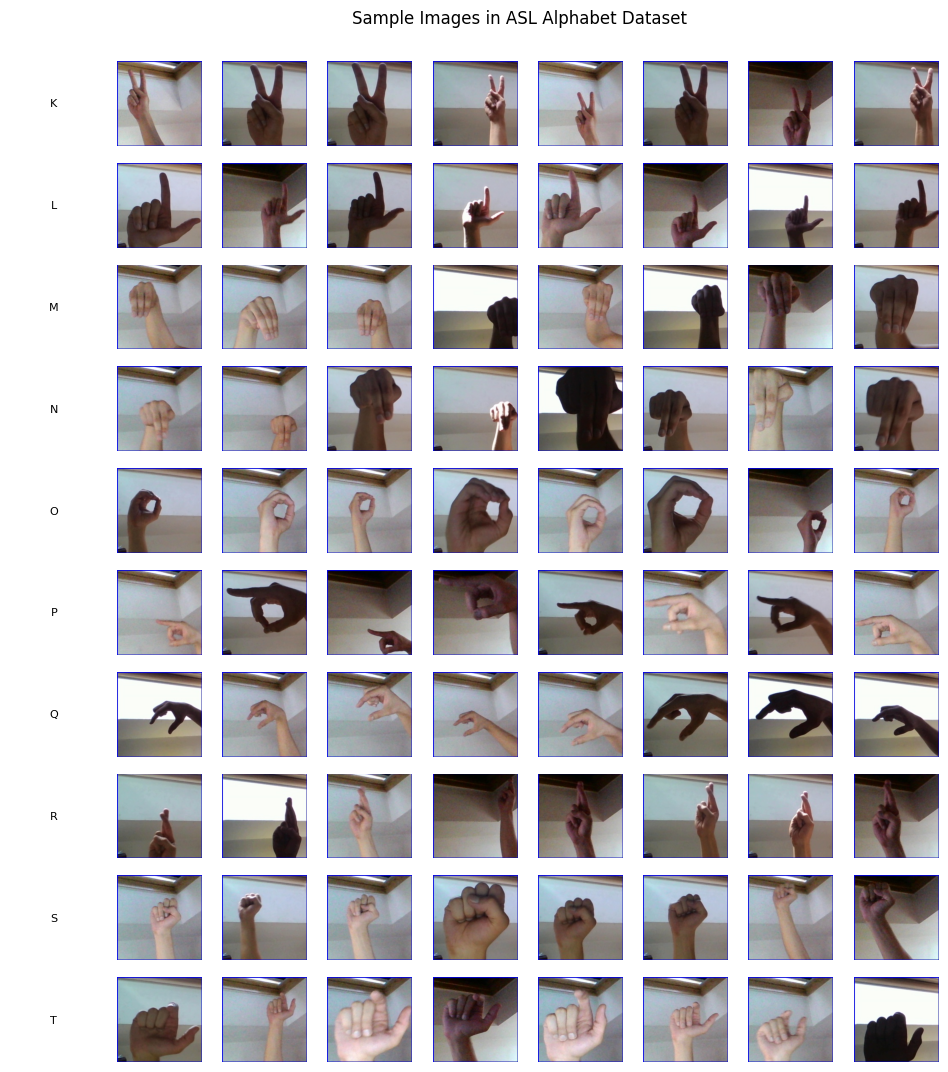

In [ ]:
sample_images(labels[10:20])

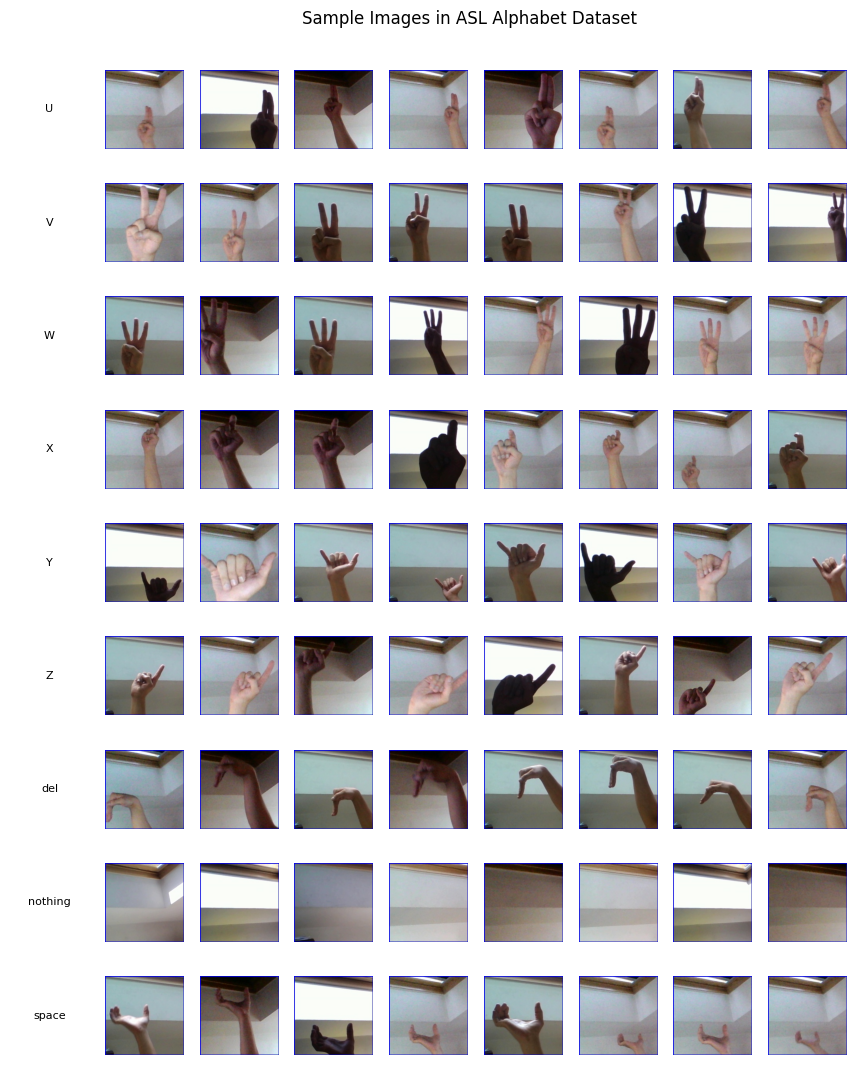

In [ ]:
sample_images(labels[20:])

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">2.2. Data Preprocessing</h2>
</div>

In [ ]:
# Initialize Lists to Store Image Paths and Corresponding Labels
list_path = []    # List to store full paths to each image
list_labels = []  # List to store corresponding labels for each image

# Loop Through Each Label to Collect Image Paths and Labels
for label in labels:
    # Construct the path pattern to match all images in the current label's directory
    label_path = os.path.join(TRAIN_PATH, label, "*")

    # Use glob to find all image files matching the pattern in the current label's directory
    image_files = glob.glob(label_path)

    # Create a list with the current label repeated for each image found
    sign_label = [label] * len(image_files)

    # Extend the lists with the paths and corresponding labels
    list_path.extend(image_files)
    list_labels.extend(sign_label)

# Create a DataFrame to Store the Metadata
metadata = pd.DataFrame({
    "image_path": list_path,  # Column with full paths to images
    "label": list_labels      # Column with the corresponding labels
})

# Display the Metadata DataFrame
metadata


image_path  label
0      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                  ...    ...
86995  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86996  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86997  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86998  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86999  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[87000 rows x 2 columns]

In [ ]:
# Split Dataset to Train (70%), Validation (15%), and Test (15%)

# First Split: Create Train (85%) and Test (15%) Datasets
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"],   # Feature: Image paths
    metadata["label"],        # Target: Labels
    test_size=0.15,           # 15% of the data will be reserved for testing
    random_state=2023,        # Set a random state for reproducibility
    shuffle=True,             # Shuffle the data before splitting
    stratify=metadata["label"]  # Ensure the label distribution is preserved
)

# Create DataFrame for Training Data After the First Split
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

# Second Split: Further Split Train Data into Train (70%) and Validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"],  # Feature: Image paths
    data_train["label"],       # Target: Labels
    test_size=0.15 / 0.70,     # 15% out of the initial 70% (about 21.4% of the current train data)
    random_state=2023,         # Same random state for reproducibility
    shuffle=True,              # Shuffle the data before splitting
    stratify=data_train["label"]  # Ensure the label distribution is preserved
)

# Create Final DataFrames for Train, Validation, and Test Sets
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

# Display the Train, Validation, and Test DataFrames
display(data_train)
display(data_val)
display(data_test)


image_path    label
51901  /kaggle/input/asl-alphabet/asl_alphabet_train/...        R
51887  /kaggle/input/asl-alphabet/asl_alphabet_train/...        R
5050   /kaggle/input/asl-alphabet/asl_alphabet_train/...        B
29446  /kaggle/input/asl-alphabet/asl_alphabet_train/...        J
58405  /kaggle/input/asl-alphabet/asl_alphabet_train/...        T
...                                                  ...      ...
47111  /kaggle/input/asl-alphabet/asl_alphabet_train/...        P
83611  /kaggle/input/asl-alphabet/asl_alphabet_train/...  nothing
67329  /kaggle/input/asl-alphabet/asl_alphabet_train/...        W
85296  /kaggle/input/asl-alphabet/asl_alphabet_train/...    space
60158  /kaggle/input/asl-alphabet/asl_alphabet_train/...        U

[58103 rows x 2 columns]

image_path label
24961  /kaggle/input/asl-alphabet/asl_alphabet_train/...     I
71053  /kaggle/input/asl-alphabet/asl_alphabet_train/...     X
73637  /kaggle/input/asl-alphabet/asl_alphabet_train/...     Y
72875  /kaggle/input/asl-alphabet/asl_alphabet_train/...     Y
40669  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N
...                                                  ...   ...
16474  /kaggle/input/asl-alphabet/asl_alphabet_train/...     F
62741  /kaggle/input/asl-alphabet/asl_alphabet_train/...     U
32281  /kaggle/input/asl-alphabet/asl_alphabet_train/...     K
20451  /kaggle/input/asl-alphabet/asl_alphabet_train/...     G
2962   /kaggle/input/asl-alphabet/asl_alphabet_train/...     A

[15847 rows x 2 columns]

image_path  label
73327  /kaggle/input/asl-alphabet/asl_alphabet_train/...      Y
85482  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
65607  /kaggle/input/asl-alphabet/asl_alphabet_train/...      V
53903  /kaggle/input/asl-alphabet/asl_alphabet_train/...      R
64425  /kaggle/input/asl-alphabet/asl_alphabet_train/...      V
...                                                  ...    ...
40578  /kaggle/input/asl-alphabet/asl_alphabet_train/...      N
28949  /kaggle/input/asl-alphabet/asl_alphabet_train/...      J
42094  /kaggle/input/asl-alphabet/asl_alphabet_train/...      O
5425   /kaggle/input/asl-alphabet/asl_alphabet_train/...      B
49381  /kaggle/input/asl-alphabet/asl_alphabet_train/...      Q

[13050 rows x 2 columns]

In [ ]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [ ]:
seed_everything(2024)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


# **3.Model Training**

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.1. Baseline CNN</h2>
</div>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Baseline CNN Model with Dropout and L2 Regularization
def create_baseline_cnn(input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels), num_classes=CFG.num_classes):
    """
    Builds a baseline CNN model with dropout and L2 regularization.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of output classes for classification.

    Returns:
        model (Sequential): The compiled Keras Sequential model.
    """

    # Initialize a Sequential Model
    model = Sequential([

        # Convolutional Layer 1 with L2 Regularization
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),  # Downsamples the feature map by a factor of 2
        Dropout(0.2),  # Dropout to reduce overfitting (drops 20% of the neurons randomly)

        # Convolutional Layer 2 with L2 Regularization
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),  # Downsampling
        Dropout(0.3),  # Drops 30% of the neurons randomly

        # Convolutional Layer 3 with L2 Regularization
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),  # Downsampling
        Dropout(0.4),  # Drops 40% of the neurons randomly

        # Flatten the Output for Fully Connected Layers
        Flatten(),

        # Dense (Fully Connected) Layer with L2 Regularization
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Drops 50% of the neurons randomly

        # Output Layer with Softmax Activation for Classification
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create and summarize the model
baseline_model = create_baseline_cnn()
baseline_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
baseline_model.compile(
    optimizer='adam',                # Adam optimizer for adaptive learning rate
    loss='categorical_crossentropy', # Loss function for multi-class classification
    metrics=['accuracy']             # Track accuracy during training and validation
)

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',              # Monitor the validation loss during training
    patience=5,                      # Stop training if val_loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True        # Restore the model weights from the best epoch before stopping
)

# Train the model
history = baseline_model.fit(
    train_generator,                 # Generator for the training data
    validation_data=validation_generator,  # Generator for the validation data
    epochs=5,                        # Maximum number of epochs (can be set higher; early stopping will limit it)
    callbacks=[early_stopping],      # Include early stopping callback to prevent overfitting
    verbose=1                        # Print progress during training
)


Epoch 1/5


2024-12-12 17:06:48.486370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


908/908 [==============================] - 372s 401ms/step - loss: 2.2792 - accuracy: 0.3998 - val_loss: 1.1318 - val_accuracy: 0.8092
Epoch 2/5
908/908 [==============================] - 106s 116ms/step - loss: 1.3589 - accuracy: 0.7061 - val_loss: 0.8995 - val_accuracy: 0.8945
Epoch 3/5
908/908 [==============================] - 89s 98ms/step - loss: 1.1342 - accuracy: 0.7864 - val_loss: 0.7593 - val_accuracy: 0.9369
Epoch 4/5
908/908 [==============================] - 93s 103ms/step - loss: 1.0230 - accuracy: 0.8236 - val_loss: 0.6844 - val_accuracy: 0.9565
Epoch 5/5
908/908 [==============================] - 90s 99ms/step - loss: 0.9489 - accuracy: 0.8446 - val_loss: 0.7092 - val_accuracy: 0.9377


In [ ]:
# Evaluate the model on the test set
baseline_scores = baseline_model.evaluate(test_generator)
print("Baseline CNN Test Accuracy: {:.2f}%".format(baseline_scores[1] * 100))


13050/13050 [==============================] - 71s 5ms/step - loss: 0.7052 - accuracy: 0.9423
Baseline CNN Test Accuracy: 94.23%


In [ ]:
# Plot Training and Validation Loss/Accuracy for Baseline CNN

# Extract loss and accuracy values from training history
loss = history.history['loss']            # Training loss values
val_loss = history.history['val_loss']    # Validation loss values
acc = history.history['accuracy']         # Training accuracy values
val_acc = history.history['val_accuracy'] # Validation accuracy values

# Create subplots for loss and accuracy using Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=["Baseline CNN Loss", "Baseline CNN Accuracy"])

# Loss Plot
fig.add_trace(go.Scatter(x=np.arange(1, len(loss)+1), y=loss, mode='lines+markers', name='Train Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(1, len(val_loss)+1), y=val_loss, mode='lines+markers', name='Val Loss'), row=1, col=1)

# Accuracy Plot
fig.add_trace(go.Scatter(x=np.arange(1, len(acc)+1), y=acc, mode='lines+markers', name='Train Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(1, len(val_acc)+1), y=val_acc, mode='lines+markers', name='Val Accuracy'), row=1, col=2)

# Update layout to adjust titles, size, and display options
fig.update_layout(title='Baseline CNN Training Performance', width=950, height=400, showlegend=True)

# Display the plots in an iframe for better visualization
fig.show(renderer='iframe')


<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.2. VGG16</h2>
</div>

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

None

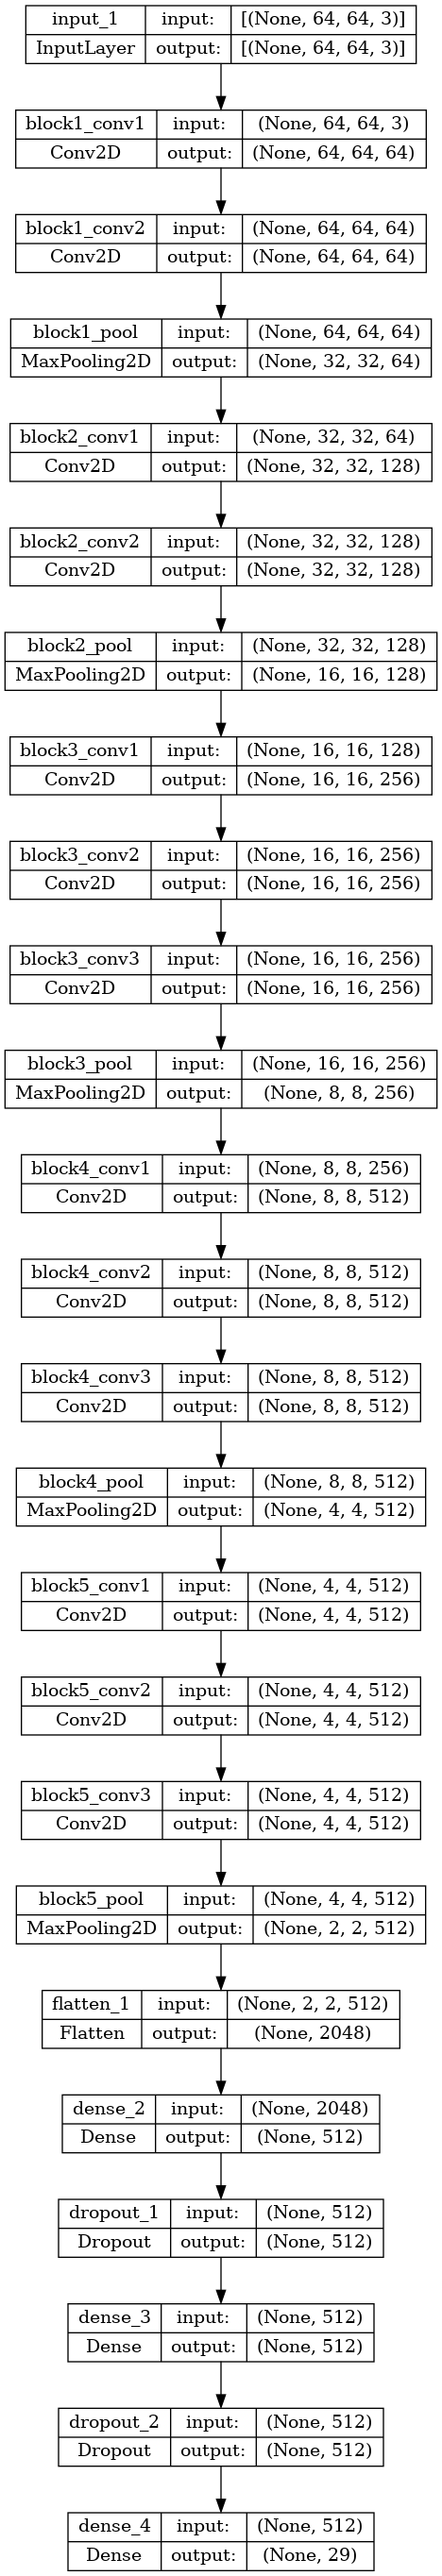

In [ ]:
# Load VGG16 model and modify for ASL recognition

# Load the VGG16 model pre-trained on ImageNet without the top (classification) layers.
# The base model will learn features from images and we will add custom layers on top for ASL recognition.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

# Freeze the weights of the base model so that only the custom layers are trained.
# This ensures that the pre-trained features from VGG16 remain fixed and only the new layers will learn.
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model to adapt it for ASL classification

# Flatten the output from the base model to connect it to fully connected (dense) layers.
x = base_model.output
x = Flatten()(x)

# Add a dense layer with 512 neurons and ReLU activation function
x = Dense(512, activation='relu')(x)

# Apply Dropout regularization to prevent overfitting (50% dropout rate)
x = Dropout(0.5)(x)

# Add another dense layer with 512 neurons and ReLU activation function
x = Dense(512, activation='relu')(x)

# Apply another Dropout layer
x = Dropout(0.5)(x)

# Add the final output layer with 29 neurons (one for each ASL class) and softmax activation for multi-class classification
predictions = Dense(29, activation='softmax')(x)

# Create the final model by specifying the input and output layers
model = Model(inputs=base_model.input, outputs=predictions)

# Display the model summary to see the architecture and layer details
display(model.summary())


In [ ]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# Train the Model
history = model.fit(
    train_generator,  # The training data generator
    steps_per_epoch=train_generator.samples // CFG.batch_size,  # Number of batches per epoch
    epochs=CFG.epochs,  # Number of epochs for training
    validation_data=validation_generator,  # The validation data generator
    validation_steps=validation_generator.samples // CFG.batch_size,  # Number of validation batches per epoch
    callbacks=[checkpoint]  # List of callbacks (in this case, saving the best model weights)
)


Epoch 1/10
907/907 [==============================] - 97s 105ms/step - loss: 1.0883 - accuracy: 0.6587 - val_loss: 0.2172 - val_accuracy: 0.9381
Epoch 2/10
907/907 [==============================] - 93s 102ms/step - loss: 0.3862 - accuracy: 0.8687 - val_loss: 0.1282 - val_accuracy: 0.9593
Epoch 3/10
907/907 [==============================] - 99s 110ms/step - loss: 0.2939 - accuracy: 0.8999 - val_loss: 0.1091 - val_accuracy: 0.9622
Epoch 4/10
907/907 [==============================] - 99s 109ms/step - loss: 0.2449 - accuracy: 0.9167 - val_loss: 0.0639 - val_accuracy: 0.9815
Epoch 5/10
907/907 [==============================] - 98s 108ms/step - loss: 0.2125 - accuracy: 0.9276 - val_loss: 0.0601 - val_accuracy: 0.9818
Epoch 6/10
907/907 [==============================] - 101s 111ms/step - loss: 0.1910 - accuracy: 0.9349 - val_loss: 0.0513 - val_accuracy: 0.9851
Epoch 7/10
907/907 [==============================] - 102s 113ms/step - loss: 0.1740 - accuracy: 0.9413 - val_loss: 0.0425 - val_

In [ ]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 67s 5ms/step - loss: 0.0317 - accuracy: 0.9904
Evaluate Test Accuracy: 99.04%


In [ ]:
# Visualize Training and Validation Results

# Create Subplot: A subplot with 1 row and 2 columns to display both the loss and accuracy plots
fig = make_subplots(
        rows=1, cols=2,  # 1 row and 2 columns for the subplots
        subplot_titles=["Model Loss", "Model Accuracy"],  # Titles for the subplots
)

# Configuration Plot: A class to store common styling parameters for markers, lines, and colors
class PlotCFG:
    marker_size = 8  # Size of the markers on the plot
    line_size = 2  # Width of the lines in the plot
    train_color = "#76503d"  # Color for training data (brownish)
    valid_color = "#deb392"  # Color for validation data (light brown)

# Loss Plot: Plotting the training and validation loss over the epochs
loss = history.history['loss']  # Training loss values
val_loss = history.history['val_loss']  # Validation loss values

# Adding training loss trace to the plot
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1),  # Epochs on the x-axis
        y=loss,  # Training loss on the y-axis
        mode="markers+lines",  # Display as both markers and lines
        marker=dict(
            color=PlotCFG.train_color,  # Color of the markers
            size=PlotCFG.marker_size,  # Size of the markers
            line=dict(color="White", width=0.5)  # White border around markers
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),  # Line color and thickness
        name="Training Loss"  # Name of the trace for legend
    ), row=1, col=1  # Position of the trace in the subplot (row 1, column 1)
)

# Adding validation loss trace to the plot
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1),  # Epochs on the x-axis
        y=val_loss,  # Validation loss on the y-axis
        mode="markers+lines",  # Display as both markers and lines
        marker=dict(
            color=PlotCFG.valid_color,  # Color of the markers for validation
            size=PlotCFG.marker_size,  # Size of the markers
            line=dict(color="White", width=0.5)  # White border around markers
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),  # Line color and thickness for validation
        name="Validation Loss"  # Name of the trace for legend
    ), row=1, col=1  # Position of the trace in the subplot (row 1, column 1)
)

# Accuracy Plot: Plotting the training and validation accuracy over the epochs
acc = history.history['accuracy']  # Training accuracy values
val_acc = history.history['val_accuracy']  # Validation accuracy values

# Adding training accuracy trace to the plot
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1),  # Epochs on the x-axis
        y=acc,  # Training accuracy on the y-axis
        mode="markers+lines",  # Display as both markers and lines
        marker=dict(
            color=PlotCFG.train_color,  # Color of the markers for training
            size=PlotCFG.marker_size,  # Size of the markers
            line=dict(color="White", width=0.5)  # White border around markers
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),  # Line color and thickness for training
        name="Training Accuracy"  # Name of the trace for legend
    ), row=1, col=2  # Position of the trace in the subplot (row 1, column 2)
)

# Adding validation accuracy trace to the plot
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1),  # Epochs on the x-axis
        y=val_acc,  # Validation accuracy on the y-axis
        mode="markers+lines",  # Display as both markers and lines
        marker=dict(
            color=PlotCFG.valid_color,  # Color of the markers for validation
            size=PlotCFG.marker_size,  # Size of the markers
            line=dict(color="White", width=0.5)  # White border around markers
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),  # Line color and thickness for validation
        name="Validation Accuracy"  # Name of the trace for legend
    ), row=1, col=2  # Position of the trace in the subplot (row 1, column 2)
)

# Update Axes: Customizing the x and y axes for both loss and accuracy plots
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)  # x-axis for loss plot
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)  # x-axis for accuracy plot
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)  # y-axis for loss plot
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)  # y-axis for accuracy plot

# Update Layout: Customizing the layout of the entire figure
fig.update_layout(
    title="Training Loss and Metrics",  # Title of the entire figure
    title_x=0.5,  # Center the title
    width=950, height=400,  # Set the dimensions of the figure
    showlegend=False,  # Disable legend (as it's unnecessary with the current plot layout)
    plot_bgcolor="White",  # Set the background color of the plot area
    paper_bgcolor="White"  # Set the background color of the entire figure
)

# Show: Display the figure with the specified settings
fig.show(iframe_connected=True)  # Render the plot as an iframe (useful for interactive notebooks)


<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">Confusion Matrix</h2>
</div>

In [ ]:
# Confusion Matrix

# Load the fine-tuned model with the best weights saved during training
fine_tuned_model = load_model("/content/asl_vgg16_best_weights.keras")

# Predict the labels for the test set using the fine-tuned model
# The `predict` method generates class probabilities for each image in the test set.
# `predictions` will be an array with shape (num_samples, num_classes), where each entry represents
# the model's predicted probabilities for each class.
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels for the test set
# `test_generator.classes` provides the true class indices for each sample in the test set.
# These are the correct labels to compare with the predictions.
true_labels = test_generator.classes

# Compute the confusion matrix using TensorFlow's `tf.math.confusion_matrix`
# `labels` are the true class labels and `predictions` are the predicted labels from the model.
# `predictions.argmax(axis=1)` converts the predicted probabilities into class indices by selecting
# the index of the maximum value for each prediction (i.e., the class with the highest probability).
# `num_classes=29` specifies that there are 29 different classes in this classification task.
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,              # True class labels from the test set
        predictions=predictions.argmax(axis=1),  # Predicted class labels (indices of max probability)
        num_classes=29                   # Total number of possible classes (29 ASL letters and symbols)
)


13050/13050 [==============================] - 50s 4ms/step


In [ ]:
# Imports
import tensorflow as tf  # Import TensorFlow for loading the model and making predictions
from tensorflow.keras.models import load_model  # Import the function to load a Keras model
from sklearn.metrics import confusion_matrix  # Import function to compute confusion matrix
import plotly.graph_objects as go  # Import Plotly for creating interactive plots
import numpy as np  # Import NumPy for numerical operations

import plotly.io as pio  # Import Plotly I/O for renderer settings
pio.renderers.default = 'kaggle'  # Use 'kaggle' renderer for compatibility with Kaggle notebooks

# Load the fine-tuned model
fine_tuned_model = load_model("/kaggle/working/asl_vgg16_best_weights.keras")  # Load the fine-tuned model from file

# Get the true labels and class indices
true_labels = test_generator.classes  # Retrieve the true labels from the test generator
class_labels = list(test_generator.class_indices.keys())  # Get class labels from the generator's class indices

# Get predictions and convert to class indices
predictions = fine_tuned_model.predict(test_generator)  # Get model predictions for the test data
predicted_classes = np.argmax(predictions, axis=1)  # Convert predicted probabilities to class indices by taking the argmax

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)  # Compute the confusion matrix comparing true labels and predictions

# Create the confusion matrix heatmap using Plotly
fig = go.Figure(
    data=go.Heatmap(
        z=cm,  # The values in the confusion matrix
        x=class_labels,  # Predicted class labels (x-axis)
        y=class_labels,  # True class labels (y-axis)
        text=cm,  # Display the values inside the heatmap cells
        texttemplate="<b>%{text}</b>",  # Make the text inside cells bold
        textfont={"size":8},  # Set font size for text inside the heatmap cells
        colorscale=[[0, '#f4f4f4'], [1.0, '#76503d']],  # Define a color scale for the heatmap
        showscale=False,  # Disable the color scale legend
        ygap=5,  # Set vertical gap between cells in the heatmap
        xgap=5,  # Set horizontal gap between cells in the heatmap
        hovertemplate=  # Define the information to display when hovering over a cell
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"  # Label for the heatmap trace
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)  # Set x-axis label and font size
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)  # Set y-axis label and font size

# Update Layout
fig.update_layout(
    title_text='Confusion Matrix',  # Set the title of the plot
    title_x=0.5,  # Center the title
    font_size=14,  # Set font size for the plot
    width=1050,  # Set the width of the plot
    height=1115,  # Set the height of the plot
    plot_bgcolor='white',  # Set the background color of the plot to white
    showlegend=False  # Hide the legend as it's not needed for a heatmap
)

# Show the figure
fig.show(renderer='iframe')  # Display the heatmap in an interactive format using the 'iframe' renderer


13050/13050 [==============================] - 50s 4ms/step


# **5.Model Explainability**

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">5.1. t-SNE Visualization</h2>
</div>

In [ ]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test["label"]==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

image_path  label
0     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                 ...    ...
2895  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2896  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2897  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2898  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2899  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[2900 rows x 2 columns]

100%|██████████| 2900/2900 [03:10<00:00, 15.24it/s]


In [ ]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.004s...
[t-SNE] Computed neighbors for 2900 samples in 0.282s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 4.914124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.266277
[t-SNE] KL divergence after 1000 iterations: 0.600644


image_path  label  tsne_feat_0  \
0     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     2.521914   
1     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     1.285982   
2     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     4.699871   
3     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     2.583227   
4     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A     3.710413   
...                                                 ...    ...          ...   
2895  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space   -14.972749   
2896  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space   -17.025871   
2897  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space   -21.643456   
2898  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space   -19.348486   
2899  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space   -21.424665   

      tsne_feat_1  
0       18.810493  
1       18.622229  
2       14.541898  
3       20.058191  
4       16.966511  
...           ...  
2895    -9.806318  
2896   -14.406055  
2897   -16.648365  
2898   -18.835142  
2899   -16.975582  

[2900 rows x 4 columns]

In [ ]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000",
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show(renderer='iframe')

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">5.2. Class Activation Maps (Grad-CAM)</h2>
</div>

In [ ]:
# https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):

        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
def gradcam_images(labels):
    # Create Subplots
    fig, axs = plt.subplots(len(labels), 7, figsize=(12, 10))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_data = data_test[data_test["label"]==label][:2].reset_index(drop=True)

        for j in range(2):
            # Read Original Image
            orig = cv2.imread(label_data["image_path"][j])
            orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

            # Preprocess and Predict Label from Image
            img = load_img(label_data["image_path"][j], target_size=(CFG.img_height, CFG.img_width))
            img = img_to_array(img) / 255.
            img = np.expand_dims(img, axis=0)
            img_label_ci = fine_tuned_model.predict(img, verbose=0)
            img_label = np.argmax(img_label_ci[0])

            # Compute Heatmap using GradCAM
            cam = GradCAM(fine_tuned_model, img_label)
            heatmap = cam.compute_heatmap(img)

            # Overlay Heatmap with Original Image
            heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

            # Show Original, Heatmap, and Overlap Heatmap Images
            axs[i, j*3+1].imshow(orig)
            axs[i, j*3+1].axis("off")
            axs[i, j*3+2].imshow(heatmap)
            axs[i, j*3+2].axis("off")
            axs[i, j*3+3].imshow(output)
            axs[i, j*3+3].axis("off")

    # Title
    plt.suptitle("Class Activation Maps (GradCAM) in Test Images", x=0.55, y=0.92)

    # Show
    plt.show()

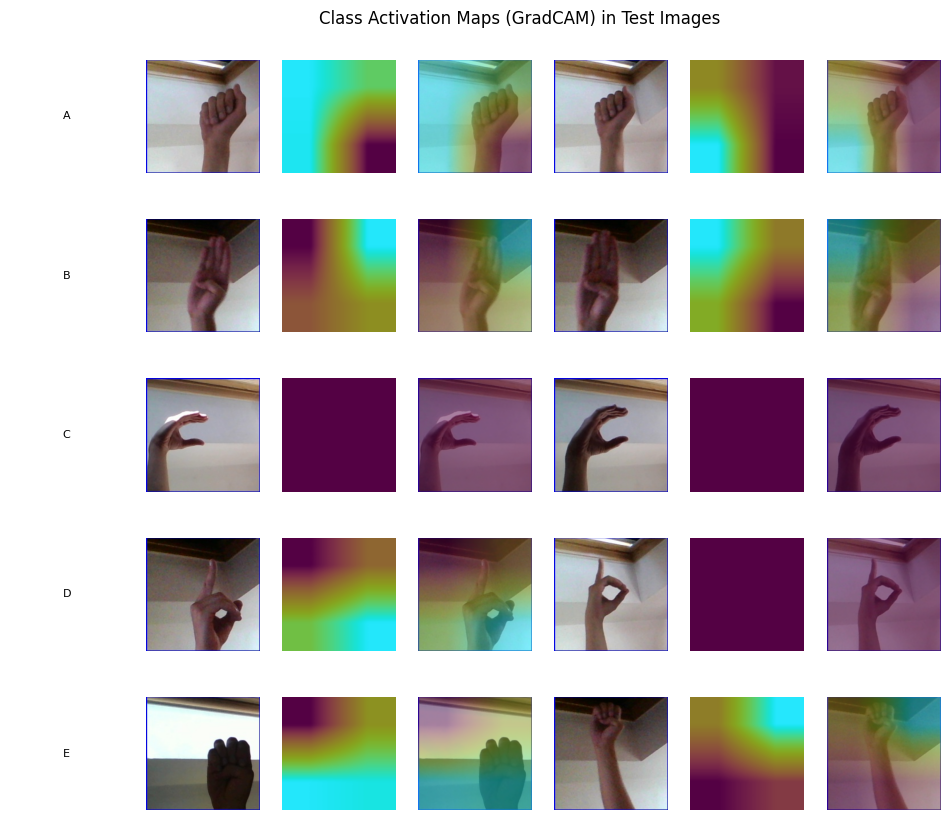

In [ ]:
gradcam_images(labels[:5])

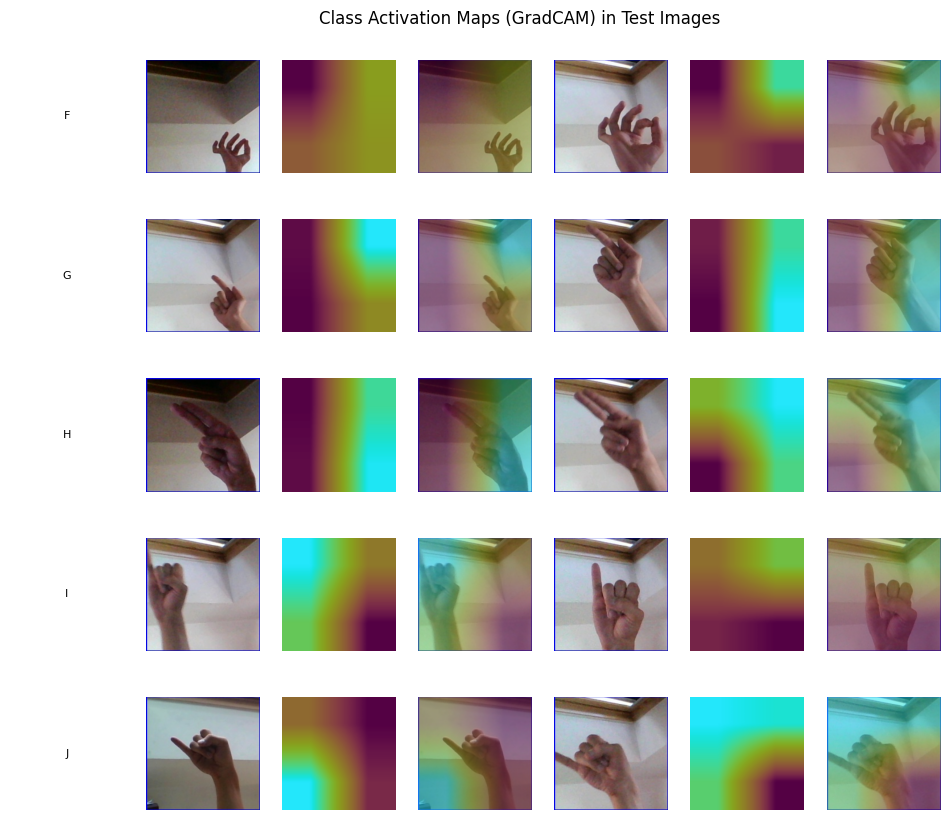

In [ ]:
gradcam_images(labels[5:10])

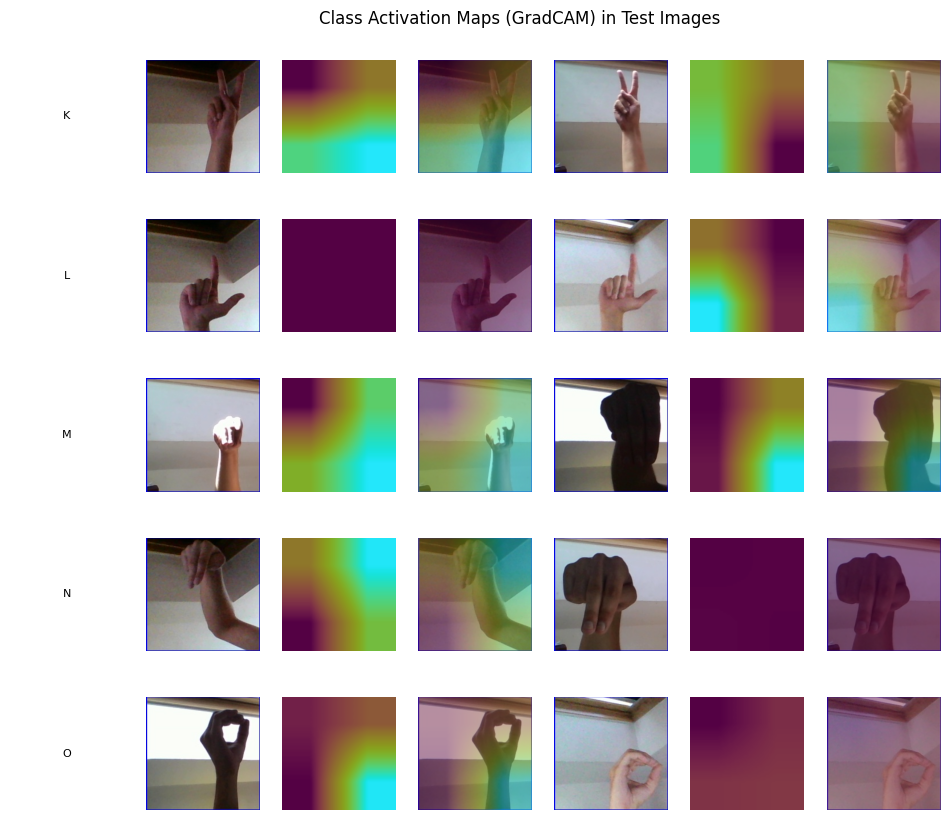

In [ ]:
gradcam_images(labels[10:15])